Import all the libraries


In [96]:
import time
from itertools import cycle, islice
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.decomposition import PCA





Set up cluster parameters

In [97]:
# Set up cluster parameters
default_base = {
    "n_clusters": 5,
    "random_state": 42,
}

# Update parameters with your specific values if needed
params = default_base.copy()

Get the newest data 

In [98]:
def get_newest_data():
    # Check for env variable - error if not present
    envP7RootDir = os.getenv("P7RootDir")
    if envP7RootDir is None:
        print("---> If you are working in vscode\n---> you need to restart the aplication\n---> After you have made a env\n---> for vscode to see it!!")
        print("---> You need to make a env called 'P7RootDir' containing the path to P7 root dir")
        raise ValueError('Environment variable not found (!env)')

    #Enter CSV directory
    labeled_workDir = envP7RootDir + "\\Data\\CSV files"
    unlableled_work2Dir = envP7RootDir + "\\Data\\Refined data\\Unlabeled data\\PROCESSED DATA"

    #Find all dates from the files
    dirDates = []
    for file in os.listdir(labeled_workDir):
        onlyDate = re.findall(r'\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}', file)
        new_string = str(onlyDate).replace("-", "")
        new_string = new_string.replace("_","")
        new_string = new_string.strip("[]'")
        dirDates.append([int(new_string),file])

    #Sort dates and return newest
    labeledDirDates = sorted(dirDates,key=lambda l:l[1],reverse=True) 

    #Find all dates from the files
    dirDates = []
    for file in os.listdir(unlableled_work2Dir):
        onlyDate = re.findall(r'\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}', file)
        new_string = str(onlyDate).replace("-", "")
        new_string = new_string.replace("_","")
        new_string = new_string.strip("[]'")
        dirDates.append([int(new_string),file])

    #Sort dates and return newest
    unlabeledDirDates = sorted(dirDates,key=lambda l:l[1],reverse=True)

    labeledDataFileName = labeled_workDir + "\\" + labeledDirDates[0][1]
    unlabeledDataFileName = unlableled_work2Dir + "\\" + unlabeledDirDates[0][1]
    
    return(labeledDataFileName, unlabeledDataFileName)
labeledDataFileName, unlabeledDataFileName = get_newest_data()


Read the CSV file

In [99]:
df = pd.read_csv(labeledDataFileName)
dt = pd.read_csv(unlabeledDataFileName)



#Remove filename coloum
X = df.drop(['Filename'], axis=1)
Y = dt.drop(['Filename'], axis=1)



#Keep data and lables
labeledData = X.iloc[:, 1:].values
labeledlabels = X.iloc[:, 0].values

unlabeledData = Y.iloc[:, 1:].values
unlabeledlabels = Y.iloc[:, 0].values

#Scale the data to have 0 mean and variance 1 - recommended step by sklearn
X = StandardScaler().fit_transform(labeledData)

#Scale the data to have 0 mean and variance 1 - recommended step by sklearn
Y = StandardScaler().fit_transform(unlabeledData)

# Apply PCA to reduce the dimensionality of the data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
Y_pca = pca.fit_transform(Y)


# Print the explained variance ratio to understand how much variance is captured by the components
print("Explained variance ratio for labeled data:", pca.explained_variance_ratio_)
print("Explained variance ratio for unlabeled data:", pca.explained_variance_ratio_)

Explained variance ratio for labeled data: [0.39804021 0.13089746]
Explained variance ratio for unlabeled data: [0.39804021 0.13089746]


Define Clustering Algorithms

In [100]:
# Create kMeans cluster objects
two_means = cluster.MiniBatchKMeans(
    n_clusters=params["n_clusters"],
    random_state=params["random_state"],
)
gmm = mixture.GaussianMixture(
    n_components=params["n_clusters"],
    covariance_type="full",
    random_state=params["random_state"],
)

clustering_algorithms = (
    ("MiniBatch\nKMeans", two_means),
    ("Gaussian\nMixture", gmm),
)


Plot Each Clustering Algorithm

In [101]:
def plot_clustering(algorithm, name, X):
    t0 = time.time()

    algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, "labels_"):
        y_pred = algorithm.labels_.astype(int)
    else:
        y_pred = algorithm.predict(X)

    plt.figure(figsize=(6, 6))
    plt.title(name, size=18)

    colors = np.array(
        list(
            islice(
                cycle(
                    [
                        "#377eb8",
                        "#ff7f00",
                        "#4daf4a",
                        "#f781bf",
                        "#a65628",
                        "#984ea3",
                        "#999999",
                        "#e41a1c",
                        "#dede00",
                    ]
                ),
                int(max(y_pred) + 1),
            )
        )
    )
    # Add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    plt.xlim(np.min(X[:, 0]), np.max(X[:, 0]))
    plt.ylim(np.min(X[:, 1]), np.max(X[:, 1]))
    plt.text(
        0.99,
        0.01,
        ("%.2fs" % (t1 - t0)).lstrip("0"),
        transform=plt.gca().transAxes,
        size=15,
        horizontalalignment="right",
    )
    plt.show()


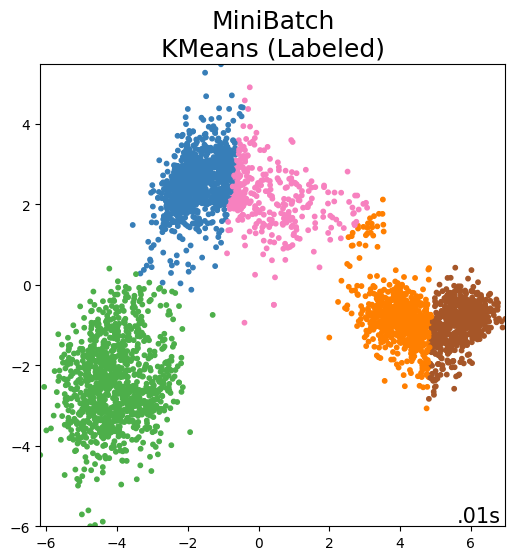

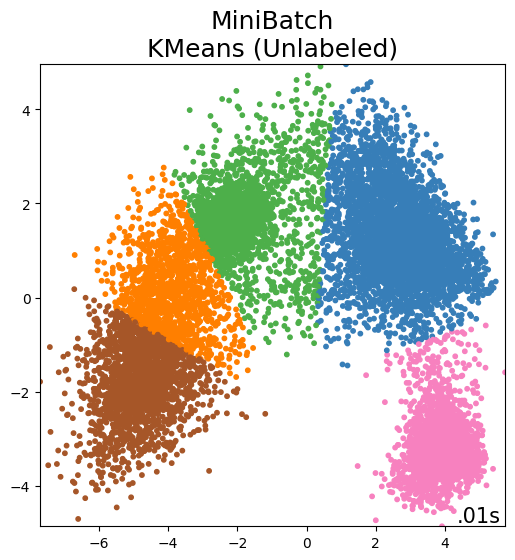

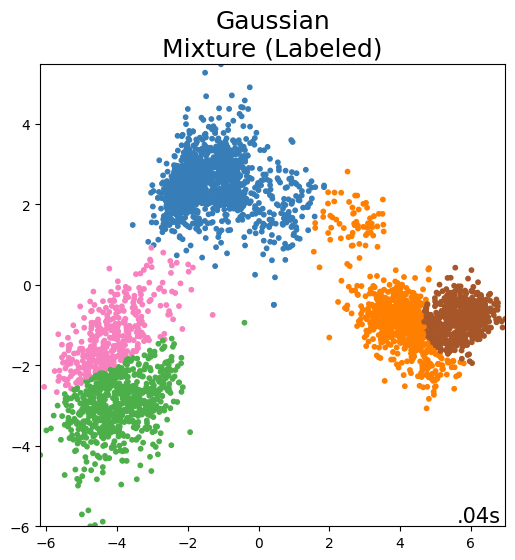

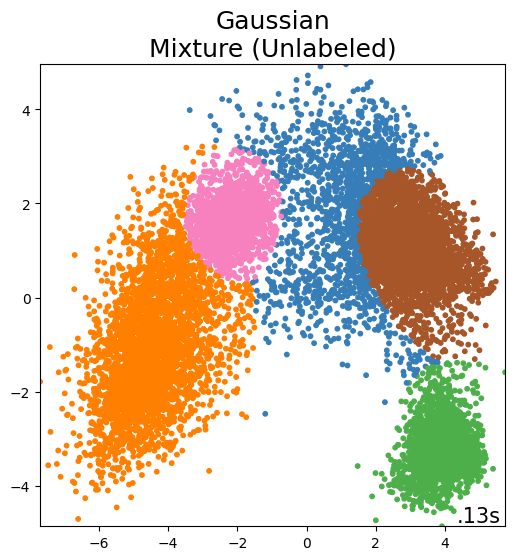

In [102]:
for name, algorithm in clustering_algorithms:
    plot_clustering(algorithm, name + ' (Labeled)', X_pca)
    plot_clustering(algorithm, name + ' (Unlabeled)', Y_pca)

Compare the two datasets. Appareantly i made a croissant

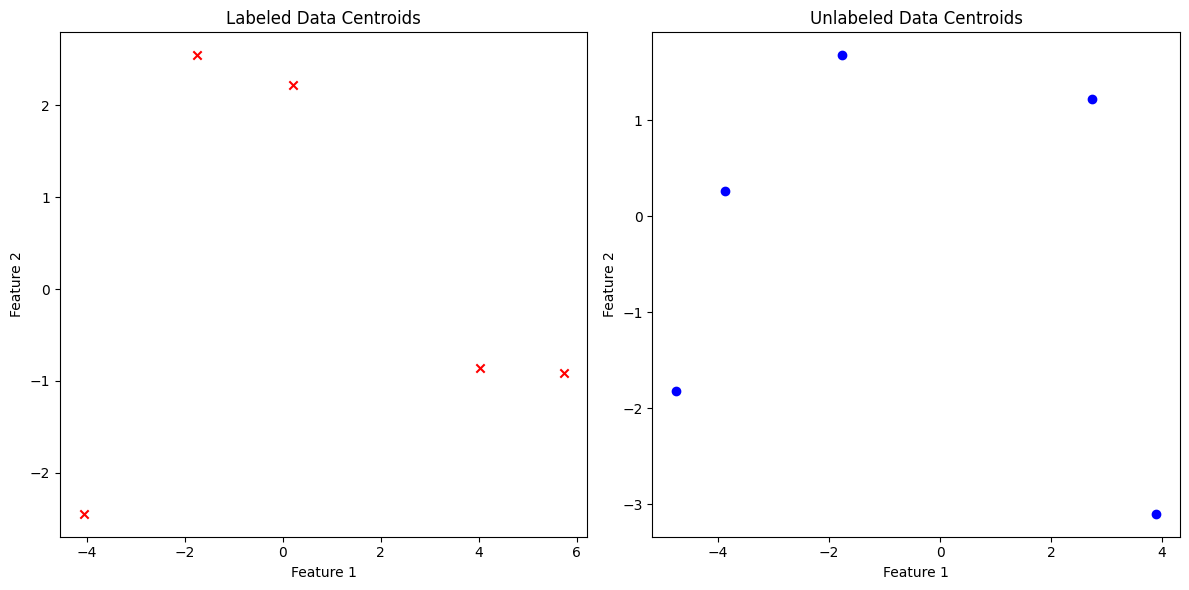

In [103]:
# Fit the MiniBatchKMeans algorithm to both datasets
two_means.fit(X_pca)
labeled_centroids = two_means.cluster_centers_

two_means.fit(Y_pca)
unlabeled_centroids = two_means.cluster_centers_

# Plot the centroids for comparison
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(labeled_centroids[:, 0], labeled_centroids[:, 1], c='red', marker='x')
plt.title('Labeled Data Centroids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(1, 2, 2)
plt.scatter(unlabeled_centroids[:, 0], unlabeled_centroids[:, 1], c='blue', marker='o')
plt.title('Unlabeled Data Centroids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

Make new CSV file with the unlabeled labels